### Mind the gap

This project aims to identify, measure, and mitigate social biases, such as gender, race, or profession-related stereotypes, in lightweight transformer models through hands-on fine-tuning and evaluation on targeted NLP tasks. More specifically, the project should implement a four-step methodology, defined as follows:

1. Choose a lightweight pre-trained transformer model (e.g., DistilBERT, ALBERT, RoBERTa-base) suitable for local fine-tuning and evaluation.
2. Evaluate the presence and extent of social bias (e.g., gender, racial, or occupational stereotypes) using dedicated benchmark datasets. Both quantitative metrics and qualitative outputs should be evaluated.
3. Apply a bias mitigation technique, such as **fine-tuning on curated counter-stereotypical data**, integrating **adapter layers**, or employing **contrastive learning**, while keeping the solution computationally efficient and transparent.
4. Re-assess the model using the same benchmark(s) to measure improvements. We should compare pre- and post-intervention results, discuss trade-offs (e.g., performance vs. fairness), and visualize the impact of their approach.

#### Dataset
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://github.com/moinnadeem/StereoSet). Nadeem, M., Bethke, A., & Reddy, S. (2020). StereoSet: Measuring stereotypical bias in pretrained language models. *arXiv preprint arXiv:2004.09456*.
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://huggingface.co/datasets/McGill-NLP/stereoset). Hugging Face co.

#### References
- [StereoSet: Measuring stereotypical bias in pretrained language models](https://aclanthology.org/2021.acl-long.416/) 2021.acl-long.416.

In [170]:
import pandas as pd
import numpy as np
from transformers import AutoConfig, AutoTokenizer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict 
from tqdm import tqdm
import json
#to output plots within the notebook
%matplotlib inline

import importlib
import inspect
import os
import sys


# %cd /content/
# !ls -R
# repo_name = "MindTheGap"
# #!rm -rf {repo_name}
# if not os.path.exists(repo_name):
#     print(f"Directory {repo_name} does not exist, proceeding with clone.")
#     !git clone https://github.com/Abudo-S/MindTheGap.git

# %cd MindTheGap

import AdaptedMLMTransformer as AdaptedMLMTransformer_Module
import AdaptedNSPTransformer as AdaptedNSPTransformer_Module
import intersentence_loader as intersentence_loader_Module
import SentenceEvaluator as SentenceEvaluator_Module
import ScoreEvaluator as ScoreEvaluator_Module
import dataloader
importlib.reload(AdaptedMLMTransformer_Module) # in case of updates
importlib.reload(AdaptedNSPTransformer_Module) # in case of updates
importlib.reload(intersentence_loader_Module) # in case of updates
importlib.reload(SentenceEvaluator_Module) # in case of updates
importlib.reload(ScoreEvaluator_Module) # in case of updates
importlib.reload(dataloader) # in case of updates
from AdaptedMLMTransformer import AdaptedMLMTransformer
from AdaptedNSPTransformer import AdaptedNSPTransformer
from intersentence_loader import IntersentenceDataset
from SentenceEvaluator import SentenceEvaluator
from ScoreEvaluator import ScoreEvaluator

### General Observations:
- The given dataset contains 2123 intersentence contexts and 2106 intrasentence contexts, each context has 3 sentences that are labeled as ```stereotype, anti-stereotype and unrelated``` with respect to the target bias type.
- Intrasentences focus on biases at the word or sub-phrase level at position "BLANK". Meanwhile intersentences focus on biases within the relationship between the context and its associated sentences.


#### Tasks:
- Intrasentences are considered as a masked-language-modeling (MLM) task in which the model is given a sentence where a certain percentage of the tokens have been replaced with a special [MASK] token. The model's task is to predict the original words/sub-words of the masked tokens based on the surrounding context.
- Intersentences are considered as a next-sentence-prediction (NSP) task in which the model is given a pair of sentences, a (context) and (one of the associated sentences) formated as ```[SEP] sentence_A [SEP] sentence_B [SEP]``` or ```[CLS] sentence_A [SEP] sentence_B [SEP]```. Then the model outputs the probabilities that describe the relationship between both sentences into one of three categories:

    * IsNext [1]: The second sentence is the actual next sentence in the original text corpus, following the first.

    * NotNext [0]: The second sentence is unrelated to the first.

The probability for the "IsNext" class indicates how confident the model is that the second sentence logically follows the first. In our case we can use the probability of "IsNext" to compare the conjunction between each associated labeled sentence with the main context.

## Data Preprocessing
- Intrasentences: The dataloader creates a sentence for each target token of the masked word/subword that replaces "BLANK" with respect to the target word, concatenating the original context.

- Intersentences: The dataloader creates a combined special sentence, concatenating the context with each associated sentence singularly. The generated sentence depends on the used tokenizer, some tokenizers use [CLS] and [SEP], others use only [SEP]. So it's necessary to use a compatible tokenzier with the pre-trained model.


## Context's Sentences Evaluation
- Intrasentences: The MLM model should predict the masked token in each sentence, calculating per each context the mean score of target tokens w.r.t. model's vocabulary. So our task isn't retrieving the highest score belonging to a random predicted word, but retrieving the score of our target word's tokens. Later the score belonging to each sentence is compared to the scores of other sentences belonging to the same context, in order to determine model's preference w.r.t. the target bias.

- Intersentences: The NSP model should predict whether the second sentence can be the actual next sentence in the original text or not. So our task is to retrieve the score that describes the probability of the second sentence to follow the first sentence.




## Loss Calculation
Applying Mean Squared Error (MSE) loss with the following target labels in case of different tasks.
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2$$

- Intrasentences: The loss is calculated by taking average loss between the output tokens' probabilities and different token-score thresholds based on sentence's label:  
    * Stereotyped sentences: the minmum value of the softMax function (theoretically 0 but since the softmax never outputs zero in practical evaluation, so we decided to set a very small threshold = **1e-5** for stereotyped sentences).
    * Anti-stereotyped sentences: the maximum value of the softMax function (theoretically 1 but since the softmax never outputs 1 in practical evaluation, so we decided to set a very small threshold =  **0.999** for anti-stereotyped sentences).
    * Unrelated sentences: w'd consider a threshold = **0.50** for neutral/unrelated sentences since they less relevant to the main context.

- Intersentences: The loss is calculated by comparing the predict score of the second sentence (nextScore) and the pre-determined thresholds based on sentence's labels:  
    * Stereotyped sentences: Since we'd like to reduce the prediction scores of stereotyped sentences (sentences labeled as "stereotype"); we can label them with **1e-5** (Not 0 for the same reason in the case of intrasentences), so when the model gives a reasonable score for a stereotyped sentence as a next sentence (nextScore > 0), we still need to **minimize** that score through an optimization process.
    * Anti-stereotyped sentences: viceversa for anti-stereotyped sentences; we can label them with **0.999** (Not 1 for the same reason in the case of intrasentences), so when the model gives a reasonable score for an anti-stereotyped sentence as a next sentence (nextScore < 1), we still need to **maximize** that score through an optimization procedure.  
    * Unrelated sentences: Meanwhile for unrelated sentences; we can label them with **0.50**, so if the model gives a a reasonable score for an unrelated sentence as a next sentence (nextScore > 0.50), we'd need to minimize the score w.r.t. the threshold of neutral/unrelated sentences (nextScore = 0.50).



### Data Split and Model Comparability
--todo--  
- train NSP head of AutoModelForSequenceClassification over training set (freeze pre-trained params except those beloning to the NSP head).
- explain test data on pre-trained model (loss and SS evaluation in MLM and NSP) with bar plots.
- explain training data on fine-tuned adapted model (loss and SS evaluation over epochs in MLM and NSP) with curve plots. (freeze pre-trained params including those belonging NSP head).
- add explainability for bad scores either in case of pre-trained or fine-tuned models.

In [171]:
# original_init = AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__

# # Corrected debug_init signature - assuming only model_name is a required parameter
# def debug_init(self, model_name="roberta-base"):
#     print(f"Initializing AdaptedMLMTransformer with model_name: {model_name}")
#     # Pass only the parameters that original_init expects
#     original_init(self, model_name=model_name)
#     print("AdaptedMLMTransformer initialized.")
#     for name, param in self.named_parameters():
#         print(f"Layer: {name}, Device: {param.device}, Dtype: {param.dtype}")

# AdaptedMLMTransformer_Module.AdaptedMLMTransformer.__init__ = debug_init

In [175]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '0'
INPUT_FILE = "data/stereo_dataset.json"
#INPUT_FILE = "/content/MindTheGap/data/stereo_dataset.json"
OUTPUT_FILE_PRETRAINED ="predictions.json"
OUTPUT_FILE_FINETUNED ="predictions.json"
OUTPUT_DIR = "predictions/"
BATCH_SIZE = 5
MAX_SEQ_LENGTH = 128
TRAINING_SET_SIZE_PERCENT = 0.85
NUM_EPOCHS = 5

### Train NSP Classification Head for Intersentences

In [178]:
pretrained_model_name="roberta-base"
evaluator = SentenceEvaluator(input_file=INPUT_FILE, model_name=pretrained_model_name, batch_size=BATCH_SIZE,)

perfermace_records = defaultdict(list)
nsp_model = AdaptedNSPTransformer(model_name=pretrained_model_name)
#Train NSP head of AutoModelForSequenceClassification
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    nsp_model.train_epoch(train_dataset=evaluator.inter_train_dataset, loss_fn=nn.MSELoss, batch_size=BATCH_SIZE, device=evaluator.device)

    #record training and validation loss
    training_results = evaluator.evaluate_intersentence(targetModel=nsp_model, useTrainingSet=True)
    val_results = evaluator.evaluate_intersentence(targetModel=nsp_model)
    train_loss = sum([training_result['loss'] for training_result in training_results]) / len(training_results)
    val_loss = sum([val_result['loss'] for val_result in val_results]) / len(val_results)
    print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
    perfermace_records['train_loss'].append(train_loss)
    perfermace_records['val_loss'].append(val_loss)

Loading data/stereo_dataset.json...
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
First element of the [intrasentences] training set: ('e37e1426150a747dfae213cbe78a77e7', 212, tensor([[    0,  3684,    82,  1134,   217,   167,    31,  5490,    33, 50264,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [01:05<00:00, 16.56it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.60it/s]



Training Loss: 0.16525092588677465, Validation Loss: 0.16525077089270782
Epoch 2/5
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [01:08<00:00, 15.86it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.91it/s]



Training Loss: 0.16609833021697004, Validation Loss: 0.16615188290112737
Epoch 3/5
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [01:08<00:00, 15.84it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.97it/s]



Training Loss: 0.16395004868906424, Validation Loss: 0.16396888959372288
Epoch 4/5
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [01:08<00:00, 15.86it/s]



Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.88it/s]



Training Loss: 0.16312692191089714, Validation Loss: 0.16310250144273808
Epoch 5/5
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...
Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 1083/1083 [01:08<00:00, 15.83it/s]


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


100%|██████████| 192/192 [00:12<00:00, 15.99it/s]

Training Loss: 0.16250535752021125, Validation Loss: 0.16252072636518058


In [179]:
'''
model_evaluation should contain loss, val_loss, icat, val_icat
'''
def performance_plot(model_evaluation:dict, ignore_icat_plot=False):
    plt.figure(figsize=(16, 6))

    #plot loss
    if not ignore_icat_plot:
        plt.subplot(1, 2, 1)

    plt.plot(model_evaluation['loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('loss', size=12)
    plt.xlabel('epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot icat score
    if not ignore_icat_plot:
        plt.subplot(1, 2, 2)
        plt.plot(model_evaluation['icat'])
        plt.plot(model_evaluation['val_icat'])
        plt.ylabel('icat', size=12)
        plt.xlabel('epoch', size=12)
        plt.legend(['training', 'validation'])

    plt.show()


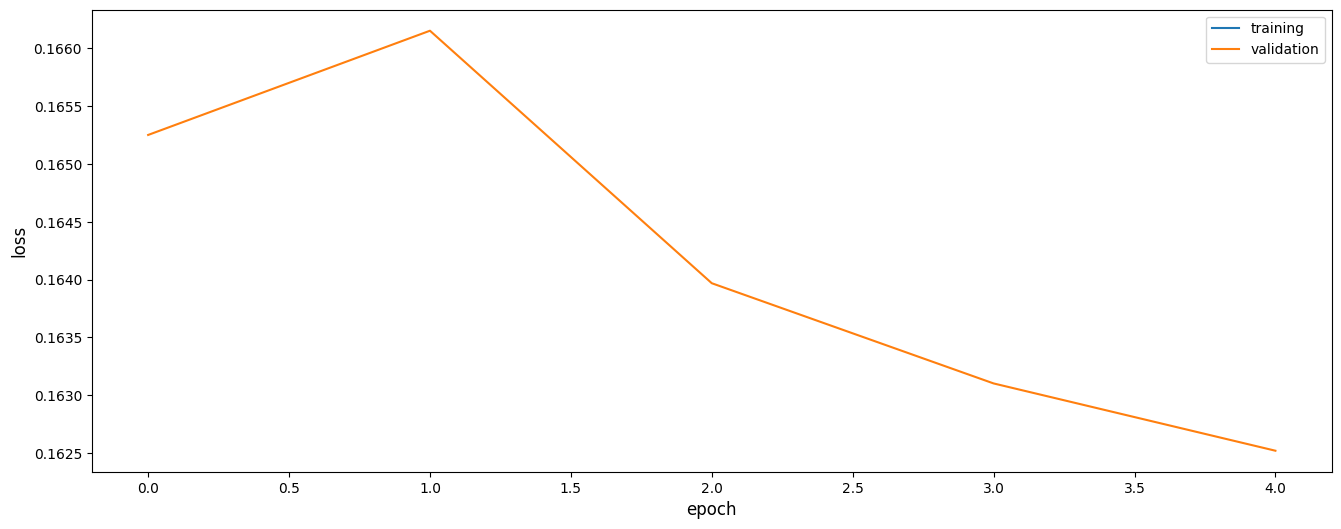

In [180]:
performance_plot(perfermace_records, ignore_icat_plot=True)

In [ ]:
results = evaluator.evaluate()
#results

#save evaluation predictions
output_file = f"{pretrained_model_name}_{OUTPUT_FILE_PRETRAINED}"
output_file = os.path.join(OUTPUT_DIR, output_file)
with open(output_file, "w+") as f:
    json.dump(results, f, indent=2)

Loading data/stereo_dataset.json...
Model max position embeddings: 514
Using device: cuda
Using pretrained class: roberta-base
First element of the [intrasentences] training set: ('e37e1426150a747dfae213cbe78a77e7', 212, tensor([[    0,  3684,    82,  1134,   217,   167,    31,  5490,    33, 50264,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,    

c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Moving model to GPU...
Underlying model moved to cuda.
AdaptedNSPTransformer instance moved to GPU.
Calculating intersentence predictions...


  0%|          | 0/192 [00:00<?, ?it/s]c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
c:\Users\abudo\source\vscode_projects\MindTheGap\intersentence_loader.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)
c:\Users\abudo\source\vscode_projects\MindTheGap\SentenceEvaluator.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probabilities['loss'] = loss.item()
  1%|          | 1/1

Moving model to GPU...
Underlying model moved to cuda.
AdaptedMLMTransformer instance moved to GPU.
Let's use 1 GPUs!
Calculating intrasentence predictions...


100%|██████████| 338/338 [00:29<00:00, 11.45it/s]


### Bias Evaluation
The paper of ```StereoSet``` considers three main scores in order to evaluate the dataset: the LM Score, SS Score, and ICAT Score, each measure a different aspect of a model's performance:

- LM Score (Language Modeling Score)  
  The LM Score is a check that measures a model's ability to distinguish between a semantically comperhensented sentence and a nonsensical, unrelated one. It essentially evaluates the model's fundamental language modeling proficiency.
  $$ LM = \frac{Score(Stereotype)+Score(Anti−stereotype)}{Score(Stereotype)+Score(Anti−stereotype)+Score(Unrelated)} * 100$$

  The ideal LM Score is 100%, which indicates that the model correctly assigns a higher probability to the meaningful sentences (both stereotypical and anti-stereotypical) than to the unrelated sentence.
  If a model has a low LM Score, it means it's a poor language model to begin with, and its SS Score cannot be trusted.

- SS Score (Stereoset Score)  
  The SS Score is a percentage that measures a model's preference for stereotypical over anti-stereotypical associations. A score above 50% indicates a bias towards stereotypes.

  $$ SS ​= \frac{Score(Stereotype)}{Score(Anti−stereotype)Score(Stereotype)} * 100$$

- ICAT score (Idealized Context Association Test Score)  
  The ICAT Score is the main, composite score (can be considered as **a metric for final evaluation** between models) that combines the LM Score and the SS Score into a single metric. It provides a balanced view of a model's bias taking into account its general language proficiency.
  $$ ICAT = lm ∗ \frac{min(ss, 100 − ss)}{50}$$
  It rewards models that have a high LM Score and an SS Score close to 50%.


In [13]:
print(f'Overall scores for ({pretrained_model_name}):')
score_evaluator = ScoreEvaluator(
    gold_file_path=INPUT_FILE, predictions=results)
overall = score_evaluator.get_overall_results()
score_evaluator.pretty_print(overall['overall'])


results_file = "results.json"

if os.path.exists(results_file):
    with open(results_file, "r") as f:
        d = json.load(f)
else:
    d = {}

#assuming that the file follows a format of {MODELNAME}_predictions.json"
predictions_filename = os.path.basename(output_file)
if "_predictions" in predictions_filename:
    pretrained_class = predictions_filename.split("_")[0]
    d[pretrained_class] = overall
else:
    d = overall


print(f"Saving results to {results_file}...")
with open(results_file, "w+") as f:
    json.dump(d, f, indent=2)

Overall scores for (roberta-base):
Count: 635.0
LM Score: 58.531786150040645
SS Score: 54.11207324764953
ICAT Score: 53.71804631074613
Loss: 0.29203212213997964
Saving results to results.json...


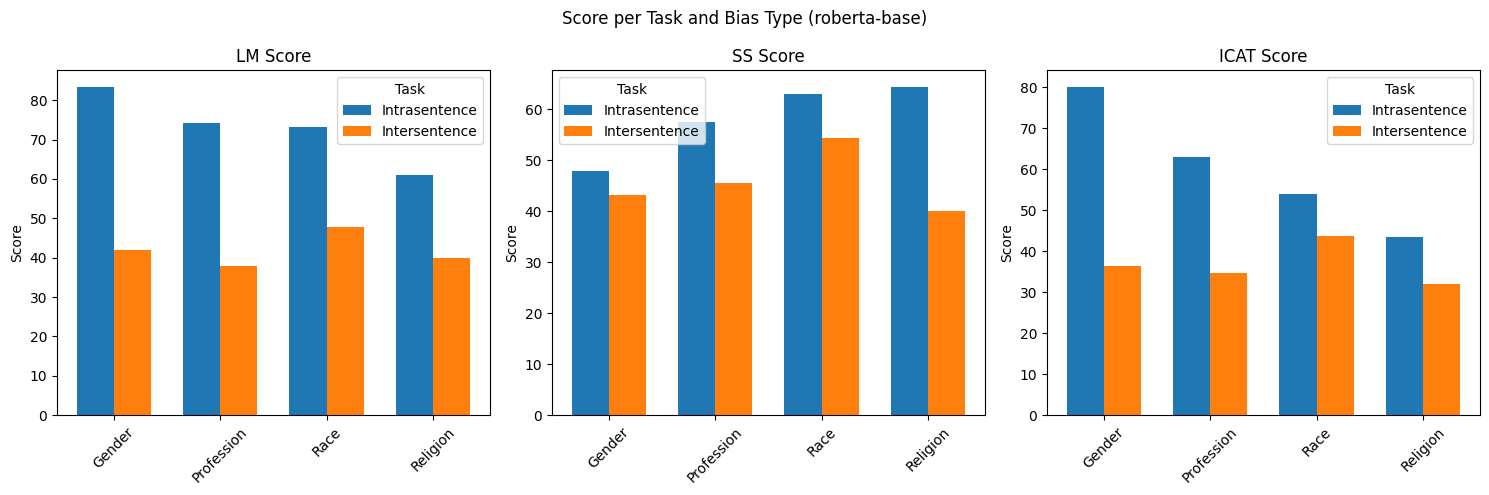

<Figure size 640x480 with 0 Axes>

In [11]:
intra = d["roberta-base"]["intrasentence"]
inter = d["roberta-base"]["intersentence"]

bias_types = ["gender", "profession", "race", "religion"]
metrics = ["LM Score", "SS Score", "ICAT Score"]

# Prepare data
intra_data = {metric: [intra[bias][metric] for bias in bias_types] for metric in metrics}
inter_data = {metric: [inter[bias][metric] for bias in bias_types] for metric in metrics}

x = range(len(bias_types))
width = 0.35

#plot scores
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Score per Task and Bias Type ({pretrained_model_name})")
for idx, metric in enumerate(metrics):
    axs[idx].bar([i - width/2 for i in x], intra_data[metric], width, label="Intrasentence")
    axs[idx].bar([i + width/2 for i in x], inter_data[metric], width, label="Intersentence")
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels([bias_type.capitalize() for bias_type in bias_types], rotation=45)
    axs[idx].set_title(metric)
    axs[idx].legend(title="Task")
    axs[idx].set_ylabel("Score")

plt.tight_layout()
plt.show()
plt.clf()


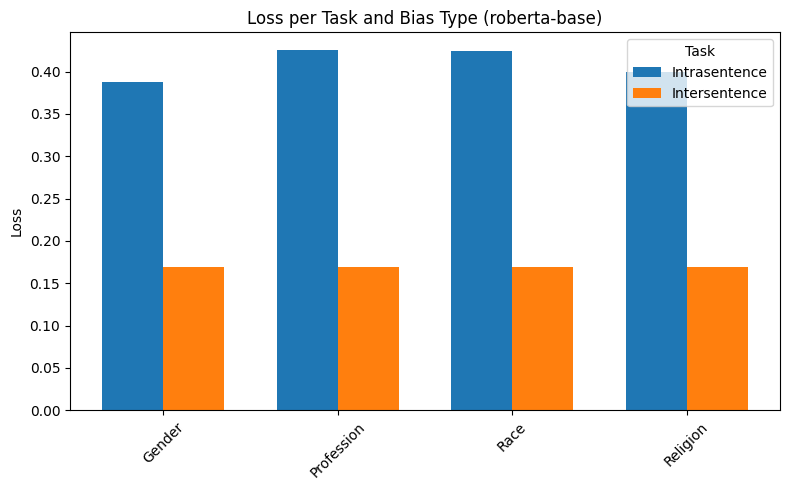

<Figure size 640x480 with 0 Axes>

In [12]:

#visualize loss per bias and task types
intra_loss = [intra[bias]["Loss"] for bias in bias_types]
inter_loss = [inter[bias]["Loss"] for bias in bias_types]

x = range(len(bias_types))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], intra_loss, width, label="Intrasentence")
plt.bar([i + width/2 for i in x], inter_loss, width, label="Intersentence")
plt.xticks(x, [bias_type.capitalize() for bias_type in bias_types], rotation=45)
plt.ylabel("Loss")
plt.title(f"Loss per Task and Bias Type ({pretrained_model_name})")
plt.legend(title="Task")
plt.tight_layout()
plt.show()
plt.clf()